# Model Training notebook

Contains the whole pipeline to train the models.  
How to use:   

Run the first cells to import all needed models and functions  
Then run the cell that loads the weights, if none are present it will create a new model  
Run the training cell and adjust N and iterations accordingly. Using a higher N will use more RAM, so you can lower N and augment eopchs.  
Finally if the results are are good, you can save the model weigths. Only do it if the results are nice, because it overwrites the old weigths.   
Then there are multiple cells that vizualize model performance

In [1]:
# Hyperparameters for simulation
nparticles = 1000   # Number of particles
nframes = 16    # Number of steps in the simulation
nposframe = 10    # Number of position per frame
dt = 0.01        # Integration time frame in second (time between two frames)
DGen = 20000        # Diffusion coefficient in nm^2 per s (=0.000001 (um^2)/s)
num_steps = nframes*nposframe
# Hyperparameters for image generation
npixel = 64 # number of image pixels
pixelsize = 100 # in nm 
fwhm_psf = 200 # full width half maximum (emulates microscope)
factor_hr = 5 # image high resulution factor
flux = 100 # number of photons per s
poisson_noise = 100 
gaussian_noise = 10
background = 100 # base background value
normalizeValue = 1000 # value by which all samples will be normalized ! Needs to be fixed and the same for all images !
n_val_im = 50
val_im_per_index = 5


In [4]:
%reload_ext autoreload
%autoreload 2
from helpers import *
from Models.modelsUtils import *
from Models.simpleCNNModel import *
from Models.ResNetModel2D import *
from Models.ResNetModel3D import *
from Models.paperCNN import *
from Models.paperCNNNoPooling import *
import os.path

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [13]:
# Models used in a dictionnary comprehension. 
# To add  anew model, simply add it to the list with the wanted train fct

lr = 0.000001
models_params = {
    #"simpleCNN": {"class": SimpleCNN, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    "resNet2D": {"class": ResNet2D, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    "resNet3D": {"class": ResNet3D, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    "ParkCNN": {"class": PaperCnn, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    #"paperCNNSGD": {"class": PaperCnn, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "sgd", "lr" :lr},
    #"paperCNNNoPool": {"class": PaperCnn, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" :lr}
}


In [14]:

for name, params in models_params.items():
    class_ = params["class"]
    # Load the model weights
    loaded_model = class_().to(device)
    filename = "modelsData/w_" + name + ".pth"
    if os.path.exists(filename):
        loaded_model = load_model_weights(loaded_model, filename)
        print(name, "Loaded existing weights")
    else:
        print(name, "Did not find weights, loaded a new model")
        
    params["loaded_model"] = loaded_model  # Update the dictionary with the loaded model
    
    if(isinstance(params["optimizer"],str)):
        if params["optimizer"] == "adam":
            params["optimizer"] = optim.Adam(loaded_model.parameters(), lr=params["lr"])
        elif params["optimizer"] == "sgd":
            params["optimizer"] = optim.SGD(loaded_model.parameters(), lr=params["lr"], momentum=0.9)
        else: 
            params["optimizer"] = optim.Adam(loaded_model.parameters(), lr=params["lr"])

Model weights loaded from modelsData/w_resNet2D.pth
resNet2D Loaded existing weights
Model weights loaded from modelsData/w_resNet3D.pth
resNet3D Loaded existing weights
Model weights loaded from modelsData/w_ParkCNN.pth
ParkCNN Loaded existing weights


In [7]:
# Print the number of parameters for each model
for name, params in models_params.items():
    print(name)
    model = params["loaded_model"]
    print(sum(dict((p.data_ptr(), p.numel()) for p in model.parameters()).values())
)

resNet2D
4908993
resNet3D
3611841
ParkCNN
2160145


In [15]:
# run this cell to reset loss histories
totalEpochs = 0
tr_loss_histories = {name: [] for name in models_params.keys()}
val_loss_histories = {}

for name, params in models_params.items():

    filename = "modelsData/l_" + name + ".npy"
    if os.path.exists(filename):
        val_loss_histories[name] = np.load(filename)
        print(name, "Loaded existing losses")
        totalEpochs = len(val_loss_histories[name])
    else:
        print(name, "Did not find losses, loaded an empty array")
        val_loss_histories[name] = np.array([])

ds = "modelsData/allDs.npy"
if os.path.exists(ds):
    allGeneratedDs = np.load(ds)
    print("Loaded existing generated Ds array")
else:
    allGeneratedDs = np.array([])   


resNet2D Loaded existing losses
resNet3D Loaded existing losses
ParkCNN Loaded existing losses
Loaded existing generated Ds array


In [21]:
def average_predictions(predictions, group_size=5):
    """
    Averages predictions in groups of `group_size`.

    Parameters:
    - predictions (torch.Tensor): Input tensor of shape (n * group_size,).
    - group_size (int): The number of elements to average in each group. Default is 5.

    Returns:
    - torch.Tensor: Tensor of shape (n,) where each element is the average of a group of `group_size` elements.
    """
    if predictions.numel() % group_size != 0:
        raise ValueError(f"The input tensor size {predictions.numel()} must be divisible by the group size {group_size}.")
    
    # Reshape to group elements for averaging
    grouped = predictions.view(-1, group_size)
    # Compute the mean along the group dimension
    averaged = grouped.mean(dim=1)
    return averaged

# load validation images
val_trajs = np.load('modelsData/validation_trajectories.npy')
val_images, valDs = generateImagesAndEstimateDFromTrajs(val_trajs,n_val_im, val_im_per_index, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue)
print(val_images.shape)
valDs = torch.tensor(valDs/1000, dtype=torch.float32, device=device)
valDsGrouped =  average_predictions(valDs)
valDs_array = valDsGrouped.view(-1).cpu().numpy()  # Convert to numpy for plotting

# Loads all the validation trajectories, 5 per value of D between 1 and 50 and generates the associated images


(250, 16, 64, 64)


This cell is used to train the models, it will generate N images for each epoch, and train all models using the same images.   
***Only run this cell if you want to train the models, else skip this cell and go to vizualisation***

In [ ]:
epochs = 20
N = 128 # Number of samples per iteration
verbose = False # print in console
for i in range(epochs):

    print(f"Generating images for iteration: {i}")

    images, estimatedDs =  generateImagesAndEstimateDMAXD(N, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue)
    
    # Divide the estimateDs by 10000 to get values in the range 0.5->70, then add them to the list of all Ds
    estimatedDs = estimatedDs / 1000
    allGeneratedDs = np.append(allGeneratedDs,estimatedDs)
    

    # Add channel dimension to images: (N, 16, 64, 64) -> (N, 16, 1, 64, 64)
    images = torch.tensor(images, dtype=torch.float32).unsqueeze(2)
    estimatedDs = torch.tensor(estimatedDs, dtype=torch.float32)


    for name, params in models_params.items():
        model = params["loaded_model"]
        train_fct = params["train_fct"]
        criterion = params["criterion"]
        optimizer = params["optimizer"]
        if(verbose):
            print("Training model:" , name)
        trained_model, tr_loss_history = train_fct(model, images, estimatedDs, device, criterion, optimizer, epochs=1, batch_size=16)
        params["loaded_model"] = trained_model

        # Compute validation loss on fixed set of images
        model_preds = predict_diffusion_coefficients(trained_model, val_images ,device)
        if(name == 'paperCNNSGD'):
            print(model_preds)
        loss = criterion(model_preds, valDs)
        val_loss_histories[name] = np.append(val_loss_histories[name],loss.item())



        # Store the single training epoch loss
        if isinstance(tr_loss_history, list) and len(tr_loss_history) > 0:
            tr_loss_histories[name].append(tr_loss_history[-1])  # Append last loss in the history
        elif isinstance(tr_loss_history, (float, int)):  # If it's a single loss value
            tr_loss_histories[name].append(tr_loss_history)
        else:
            print(f"Unexpected loss format for model {name}: {tr_loss_history}")

# add up epochs for later use 
totalEpochs = totalEpochs + epochs



Min D Value: 1.1442691862332344
Mean D Value: 20.039715252882203
Max D Value: 200.8046772627592
Number of Ds generated: 73600


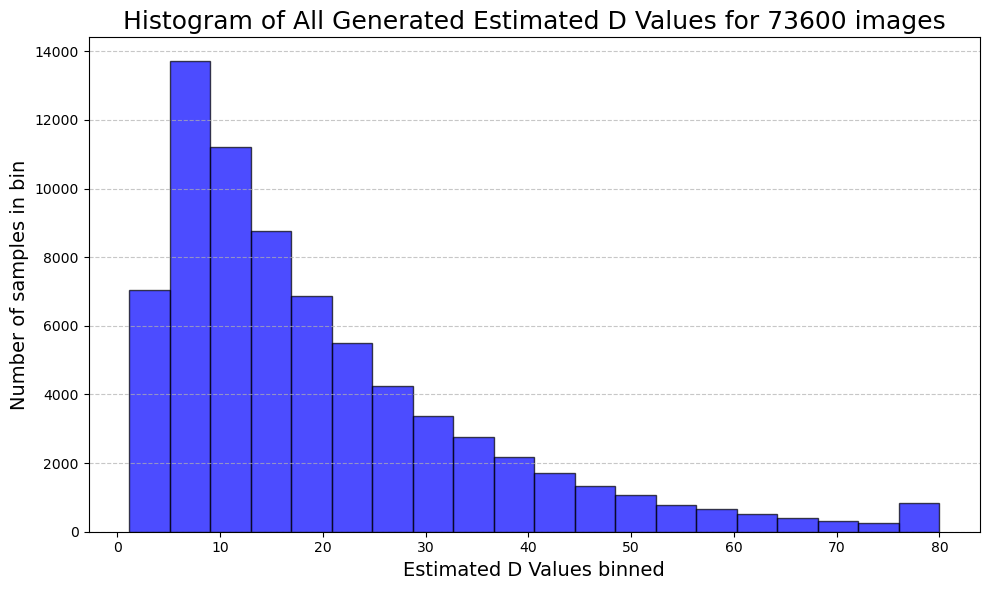

In [10]:

print("Min D Value:", np.min(allGeneratedDs))
print("Mean D Value:", np.mean(allGeneratedDs))
print("Max D Value:", np.max(allGeneratedDs))
print("Number of Ds generated:", len(allGeneratedDs))
nbrDs = len(allGeneratedDs)
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(np.clip(allGeneratedDs,0,80), bins=20, color='blue', edgecolor='black', alpha=0.7)

# Add labels, title, and grid
plt.xlabel('Estimated D Values binned', fontsize=14)
plt.ylabel('Number of samples in bin', fontsize=14)
plt.title(f'Histogram of All Generated Estimated D Values for {nbrDs} images', fontsize=18)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()

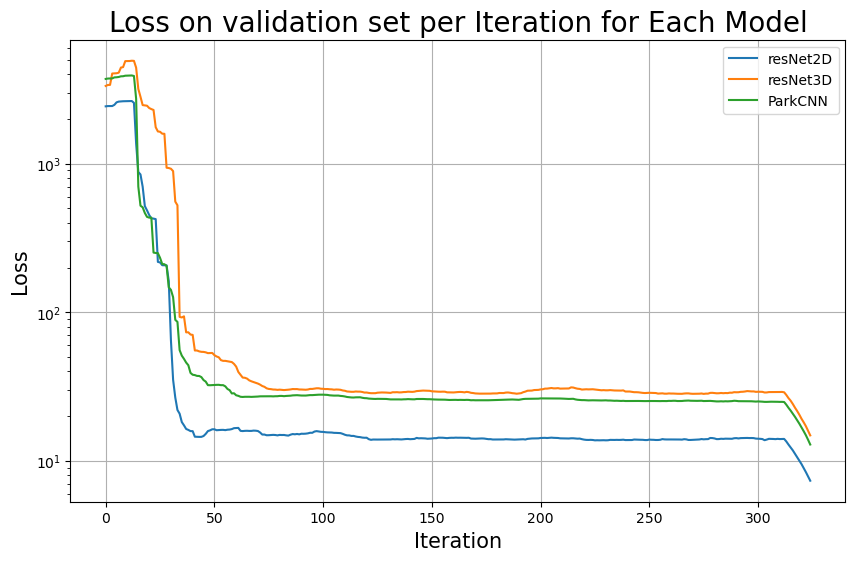

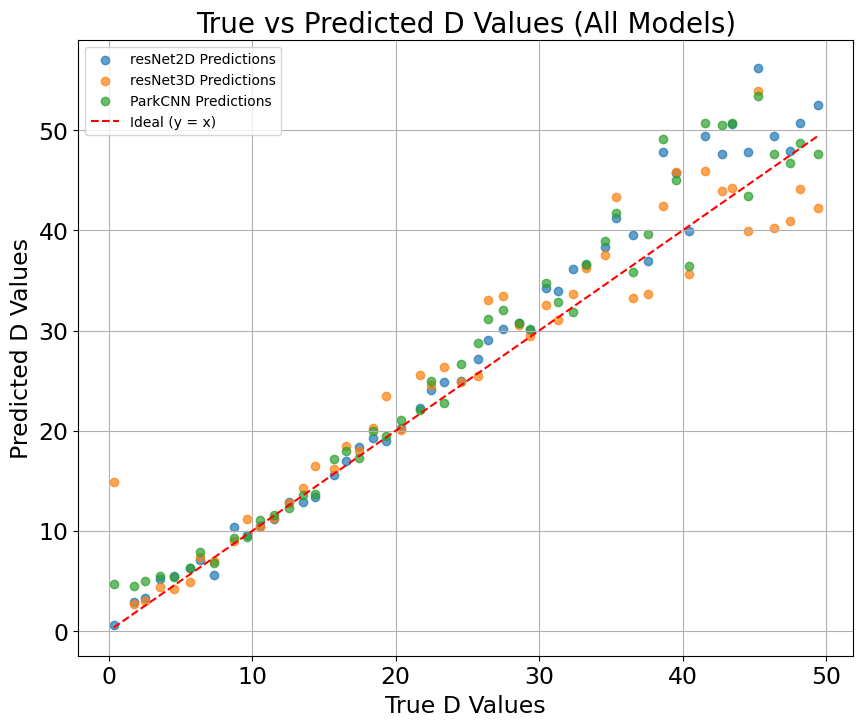

In [22]:
plt.figure(figsize=(10, 6))
for model_name, losses in val_loss_histories.items():
    stop = 200
    plt.plot(range(0, totalEpochs), moving_average(np.clip(losses,0,1000000)), label=model_name)

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('Loss on validation set per Iteration for Each Model', fontsize=20)
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 8))

# Iterate over all models to plot predictions vs true values
for name, params in models_params.items():
    # Predictions and true values
    model = params["loaded_model"]
    model_preds = predict_diffusion_coefficients(model, val_images, device)
    model_preds_gouped = average_predictions(model_preds, group_size=val_im_per_index)
    # Ensure predictions and true values are on the same device and flattened
    model_preds_gouped_array = model_preds_gouped.view(-1).cpu().numpy()  # Convert to numpy for plotting


    # Scatter plot for the current model
    plt.scatter(valDs_array, model_preds_gouped_array, alpha=0.7, label=f'{name} Predictions')

# Plot the ideal line
min_val, max_val = min(valDs_array), max(valDs_array)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal (y = x)')

# Add plot details
plt.title("True vs Predicted D Values (All Models)", fontsize=20)
plt.xlabel("True D Values", fontsize=17)
plt.ylabel("Predicted D Values", fontsize=17)
plt.legend()
plt.grid(True)
# Increase the tick label size
plt.tick_params(axis='both', which='major', labelsize=17)
plt.tick_params(axis='both', which='minor', labelsize=12)

# Show the plot
plt.show()

In [23]:
# Computes the coarse D (trajectory D) for all validation images
criterion = nn.MSELoss()
coarseDs = np.clip(compute_coarseD_for_batch(val_images, dt)/40,0,60)
coarseD_tensor = torch.tensor(coarseDs, dtype=torch.float32, device=device) 
coarseD_tensor_grouped = average_predictions(coarseD_tensor,group_size=val_im_per_index)
lossCoarseD = criterion(coarseD_tensor, valDs)  # Loss for coarseD predictions

c:\Users\Silly Emilien\Documents\EPFL\Ma1\ML\ml-project-2-big-burger\helpers.py:809: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(two_d_gaussian, (x, y), img.ravel(), p0=initial_guess, maxfev=50000)
c:\Users\Silly Emilien\Documents\EPFL\Ma1\ML\ml-project-2-big-burger\helpers.py:809: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(two_d_gaussian, (x, y), img.ravel(), p0=initial_guess, maxfev=50000)


Trajectory D Loss: 27.14340591430664
resNet2D
Model: resNet2D Loss without rotation: 33.98406219482422 Loss with rotation 30.998090744018555
resNet3D
ParkCNN


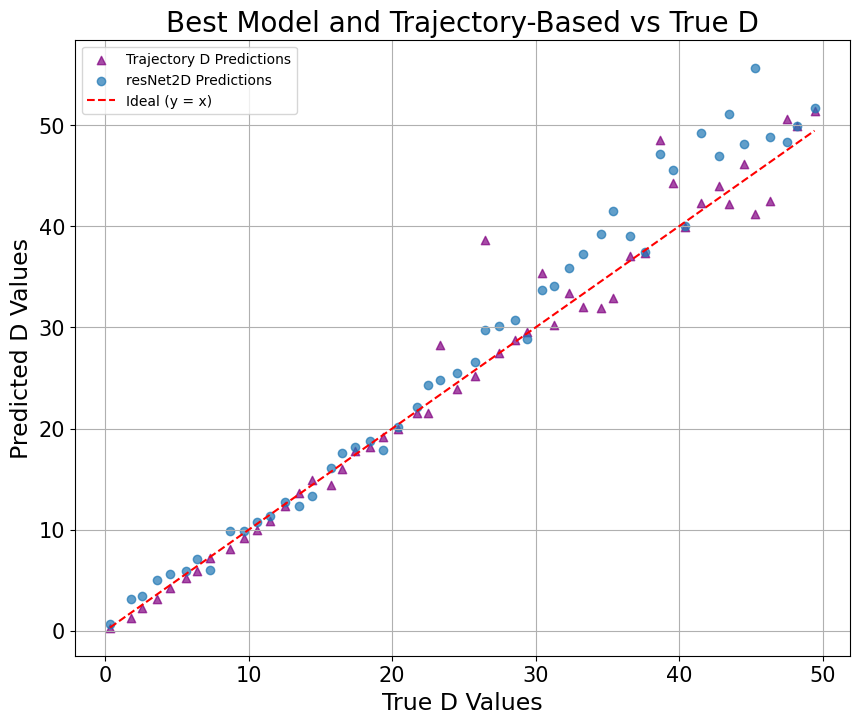

In [26]:
# Initialize a vector to store the average predictions across all models
#average_predictions = torch.zeros_like(valDs_tensor, dtype=torch.float32, device=device)
#average_predictionsRot = torch.zeros_like(valDs_tensor, dtype=torch.float32, device=device)
# Count the number of models contributing to the average
model_count = 0
plt.figure(figsize=(10, 8))

coarseD_array = coarseD_tensor_grouped.view(-1).cpu().numpy()  # Convert to numpy for plotting
plt.scatter(valDs_array, coarseD_array, color='purple', alpha=0.7, label='Trajectory D Predictions', marker='^')
print("Trajectory D Loss:", lossCoarseD.item())


# Iterate over all models to plot predictions vs true values
for name, params in models_params.items():
    print(name)
    if(name != "resNet2D"):
        continue
    # Predictions and true values
    model = params["loaded_model"]
    criterion = params["criterion"]
    model_preds = predict_diffusion_coefficients(model, val_images, device)
    model_predsRot, individualPreds = predict_with_rotations(model, val_images, device)

    model_count += 1

    # Compute losses
    loss = criterion(model_preds, valDs)
    lossRot = criterion(model_predsRot, valDs)

    # average predictions for loss
    model_preds = average_predictions(model_preds)
    model_predsRot= average_predictions(model_predsRot)

    

    # Ensure predictions and true values are on the same device and flattened
    model_preds = model_preds.view(-1).cpu().numpy()  # Convert to numpy for plotting
    model_predsRot = model_predsRot.view(-1).cpu().numpy()  # Convert to numpy for plotting
    # Scatter plot for the current model
    print("Model:", name, "Loss without rotation:", loss.item(), "Loss with rotation", lossRot.item())
        
    #plt.scatter(valDs_array, model_preds, alpha=0.7, label=f'{name} Predictions')

    plt.scatter(valDs_array, model_predsRot, alpha=0.7, label=f'{name} Predictions')

# Plot the ideal line
min_val, max_val = min(valDs_array), max(valDs_array)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal (y = x)')

# Add plot details
plt.title("Best Model and Trajectory-Based vs True D", fontsize=20)
plt.xlabel("True D Values", fontsize=17)
plt.ylabel("Predicted D Values", fontsize=17)
plt.legend()
plt.grid(True)

# Increase the tick label size
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=12)
# Show the plot
plt.show()


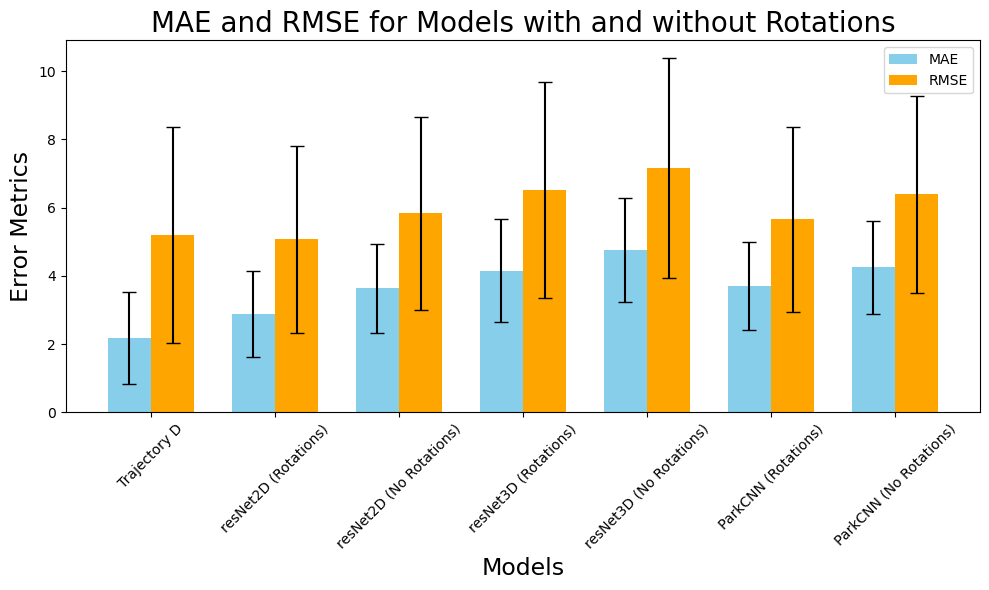

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize storage for results
mae_values = []
rmse_values = []
mae_errors = []
rmse_errors = []
labels = ["Trajectory D"]

div_factor = 3.5

# Compute MAE and RMSE for coarse D (no rotation)
mae_coarse = torch.mean(torch.abs(coarseD_tensor - valDs)).item()
rmse_coarse = torch.sqrt(criterion(coarseD_tensor, valDs)).item()
mae_std_coarse = torch.std(torch.abs(coarseD_tensor - valDs)).item() / div_factor
rmse_std_coarse = torch.std((coarseD_tensor - valDs) ** 2).sqrt().item() / div_factor

# Store coarse D metrics (no rotation)
mae_values.append(mae_coarse)
rmse_values.append(rmse_coarse)
mae_errors.append(mae_std_coarse)
rmse_errors.append(rmse_std_coarse)

# Compute MAE and RMSE for each model
for name, params in models_params.items():
    model = params["loaded_model"]
    criterion = params["criterion"]

    # Predict with rotations
    model_preds_rot, individualPreds_rot = predict_with_rotations(model, val_images, device)
    model_preds_grouped_rot = average_predictions(model_preds_rot, group_size=val_im_per_index)

    # Predict without rotations
    model_preds_no_rot = predict_diffusion_coefficients(model, val_images, device)  # Assuming model can directly predict
    model_preds_grouped_no_rot = average_predictions(model_preds_no_rot, group_size=val_im_per_index)

    # Calculate MAE and RMSE with rotations
    mae_model_rot = torch.mean(torch.abs(model_preds_rot - valDs)).item() 
    rmse_model_rot = torch.sqrt(criterion(model_preds_rot, valDs)).item() 
    mae_std_model_rot = torch.std(torch.abs(model_preds_rot - valDs)).item() / div_factor
    rmse_std_model_rot = torch.std((model_preds_rot - valDs) ** 2).sqrt().item() / div_factor

    # Calculate MAE and RMSE without rotations
    mae_model_no_rot = torch.mean(torch.abs(model_preds_no_rot - valDs)).item()
    rmse_model_no_rot = torch.sqrt(criterion(model_preds_no_rot, valDs)).item()
    mae_std_model_no_rot = torch.std(torch.abs(model_preds_no_rot - valDs)).item() / div_factor
    rmse_std_model_no_rot = torch.std((model_preds_no_rot - valDs) ** 2).sqrt().item() / div_factor

    # Store metrics with rotation
    mae_values.append(mae_model_rot)
    rmse_values.append(rmse_model_rot)
    mae_errors.append(mae_std_model_rot)
    rmse_errors.append(rmse_std_model_rot)
    labels.append(f"{name} (Rotations)")

    # Store metrics without rotation
    mae_values.append(mae_model_no_rot)
    rmse_values.append(rmse_model_no_rot)
    mae_errors.append(mae_std_model_no_rot)
    rmse_errors.append(rmse_std_model_no_rot)
    labels.append(f"{name} (No Rotations)")

# Plotting
x = np.arange(len(labels))  # X-axis positions
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))

# Bar plots for MAE and RMSE
bar1 = ax.bar(x - width / 2, mae_values, width, yerr=mae_errors, label='MAE', capsize=5, color='skyblue')
bar2 = ax.bar(x + width / 2, rmse_values, width, yerr=rmse_errors, label='RMSE', capsize=5, color='orange')

# Add labels and title
ax.set_xlabel('Models', fontsize=17)
ax.set_ylabel('Error Metrics', fontsize=17)
ax.set_title('MAE and RMSE for Models with and without Rotations', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


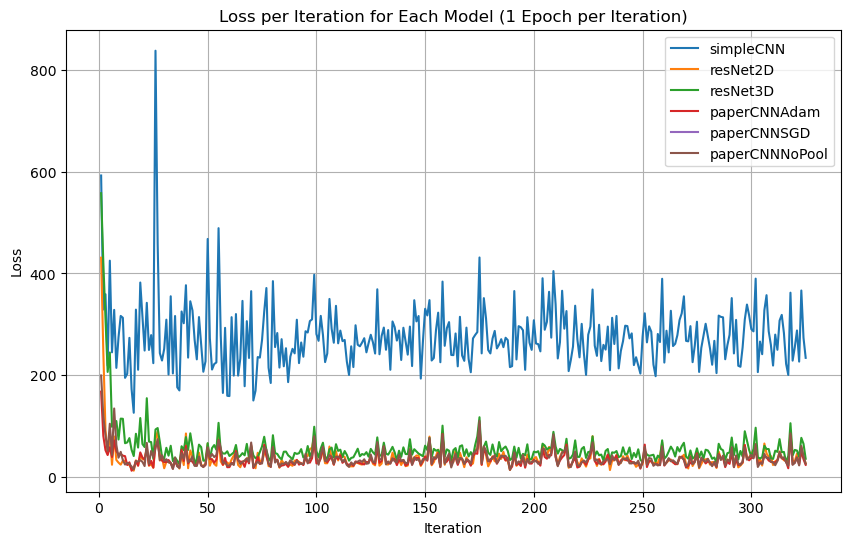

In [98]:
# Used to plot the training loss at each iteration
plt.figure(figsize=(10, 6))
for model_name, losses in tr_loss_histories.items():
    plt.plot(range(1, totalEpochs + 1), losses, label=model_name)

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss per Iteration for Each Model (1 Epoch per Iteration)')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# saves all used models 
for name, params in models_params.items():
    model = params["loaded_model"]
    filename = "modelsData/w_"+name+".pth"
    save_model_weights(model,filename)

Model weights saved to modelsData/w_simpleCNN.pth
Model weights saved to modelsData/w_resNet2D.pth
Model weights saved to modelsData/w_resNet3D.pth
Model weights saved to modelsData/w_ParkCNN.pth
Model weights saved to modelsData/w_paperCNNSGD.pth
Model weights saved to modelsData/w_paperCNNNoPool.pth


In [21]:
# Save validation Loss and epochs
np.save("modelsData/allDs.npy",allGeneratedDs)

for model_name, losses in val_loss_histories.items():
    filename = "modelsData/l_"+model_name+".npy"
    np.save(filename,losses)

In [ ]:
# run this code to generate new 50 * 5 reference images that will be used to compute the validation loss at each iteration
"""
parts = 10000
trajectories = brownian_motion(parts,nframes,nposframe,500,dt,False)
time_range = np.arange(nframes * nposframe) * dt / nposframe

nIm = 50
val_im_per_index = 5

#trajsToSave = np.zeros((nIm,val_im_per_index,nframes*nposframe,2))
#saved = np.zeros(nIm, dtype=int)

print(saved)
for p in range(parts):
    traj = trajectories[p,:]
    msd = mean_square_displacement(traj)
    estimD = estimateDfromMSD(msd,time_range)


    index = int(estimD/1000)
    if(index < nIm and saved[index] < val_im_per_index):
        indexToSave = saved[index]
        trajsToSave[index,indexToSave,...] = traj
        saved[index] = indexToSave+1

print(saved)
np.save('validation_trajectories.npy',trajsToSave)"""

[0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5]
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5]
